<a href="https://colab.research.google.com/github/happyendingddd/CRISPR_Cas9_gRNA_design/blob/main/CNN_off_target.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [137]:
import tensorflow as tf

import pandas as pd
import numpy as np
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [138]:
# 数据导入1
file_path='/content/merge_ot_sgRNA_293r_binary.csv'
data_read=pd.read_csv(file_path,sep=',')
otSeq=np.array(data_read['OT'])
guideSeq=np.array(data_read['Target sgRNA'])
labels=np.array(data_read['Cleavage Frequency'])

In [139]:
# 数据导入2（已经是编码形式）
num_read=guideSeq.shape[0]
seqdata_gP=np.load('/content/generated_ot_sgRNA_code_293r_positive.npy')[0:num_read-1]
seqdata_gN=np.load('/content/generated_ot_sgRNA_code_293r_negetive.npy')[0:num_read-1]
seqdata_g=np.vstack([seqdata_gP,seqdata_gN])
labels_gP=np.zeros(seqdata_gP.shape[0])+1
labels_gN=np.zeros(seqdata_gN.shape[0])
labels_g=np.r_[labels_gP,labels_gN]
labels_all=np.r_[labels,labels_g]

In [140]:
# 0ne_hot编码
ntmap = {'A': (1, 0, 0, 0),
         'C': (0, 1, 0, 0),
         'G': (0, 0, 1, 0),
         'T': (0, 0, 0, 1)
         }

def get_seqcode(seq):
    return list(map(lambda c: ntmap[c], seq))

def oneHotcoding(Seq):
    n=0
    for seq in Seq:
        if n==0:
            SeqcodeL=[]
        seqcode=get_seqcode(seq)
        n+=1
        SeqcodeL.append(seqcode)
        seqcode=[]
        SeqcodeA=np.array(SeqcodeL)
    return SeqcodeA

In [141]:
# OR算子编码sgRNA-DNA
def OR(a,b):
    ab=np.zeros([a.shape[0],a.shape[1]])
    for i in range(a.shape[0]):
        for j in range(a.shape[1]):
            if a[i][j] != b[i][j]:
                ab[i][j]=a[i][j]+b[i][j]
            else:
                ab[i][j]=a[i][j]
    return ab

In [142]:
# 编码
guidecode=oneHotcoding(guideSeq)
otcode=oneHotcoding(otSeq)
guide_ot_code=np.zeros((guidecode.shape[0],guidecode.shape[1],guidecode.shape[2]))
for i in range(len(guidecode)):
    guide_ot_code[i]=OR(guidecode[i],otcode[i])

In [143]:
seqdata=guide_ot_code
seqdata_all=np.vstack([seqdata,seqdata_g])
print(seqdata_all.shape)

(1606, 23, 4)


In [144]:
from sklearn.model_selection import train_test_split
train_seq,test_seq,train_lab,test_lab=train_test_split(seqdata_all,labels_all,train_size = 0.75,random_state=14,stratify=labels_all)

In [145]:
train_seq.shape

(1204, 23, 4)

In [146]:
def CNN_model():
  model = tf.keras.Sequential()
  
  model.add(layers.Conv1D(16, 3, padding='same', activation='relu', input_shape=(23,4)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv1D(64, 3,padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv1D(64, 3,padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(16, activation='relu'))
  model.add(layers.Dense(2))

  return model

In [147]:
model=CNN_model()
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 23, 16)            208       
_________________________________________________________________
batch_normalization_18 (Batc (None, 23, 16)            64        
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 23, 16)            0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 23, 16)            0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 23, 64)            3136      
_________________________________________________________________
batch_normalization_19 (Batc (None, 23, 64)            256       
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 23, 64)           

In [148]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [149]:
print(type(test_seq))
print(test_seq.shape)
# 使用原始数据作为test

<class 'numpy.ndarray'>
(402, 23, 4)


In [150]:
history = model.fit(train_seq, train_lab, epochs=50, batch_size=16,
                    validation_data=(test_seq, test_lab))

Epoch 1/50
76/76 [==============================] - 2s 11ms/step - loss: 0.7143 - accuracy: 0.6669 - val_loss: 0.6448 - val_accuracy: 0.7935
Epoch 2/50
76/76 [==============================] - 1s 8ms/step - loss: 0.3655 - accuracy: 0.8212 - val_loss: 0.5864 - val_accuracy: 0.8259
Epoch 3/50
76/76 [==============================] - 1s 8ms/step - loss: 0.3228 - accuracy: 0.8261 - val_loss: 0.4664 - val_accuracy: 0.8458
Epoch 4/50
76/76 [==============================] - 1s 8ms/step - loss: 0.2736 - accuracy: 0.8664 - val_loss: 0.3439 - val_accuracy: 0.8632
Epoch 5/50
76/76 [==============================] - 1s 8ms/step - loss: 0.3047 - accuracy: 0.8276 - val_loss: 0.2848 - val_accuracy: 0.8632
Epoch 6/50
76/76 [==============================] - 1s 8ms/step - loss: 0.2579 - accuracy: 0.8558 - val_loss: 0.2620 - val_accuracy: 0.8607
Epoch 7/50
76/76 [==============================] - 1s 8ms/step - loss: 0.2461 - accuracy: 0.8683 - val_loss: 0.2495 - val_accuracy: 0.8632
Epoch 8/50
76/76 [=

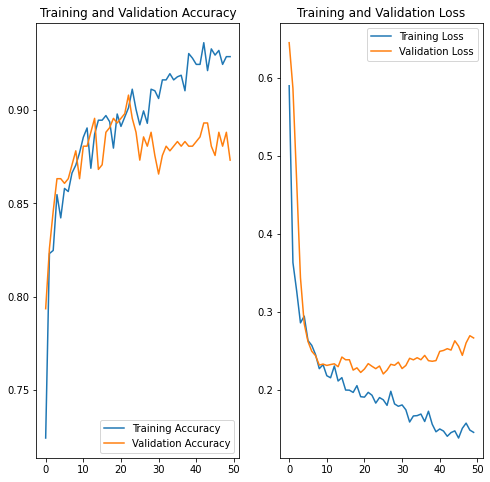

In [151]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [152]:
test_loss, test_acc = model.evaluate(test_seq,  test_lab, verbose=2)

13/13 - 0s - loss: 0.2666 - accuracy: 0.8731


In [153]:
print(test_acc)
#after:293r=0.9825360774993896;K562=0.9555555582046509

0.8731343150138855


In [154]:
# 保存模型
model.save('/content/model_trained.h5') 


In [155]:
# 加载模型，同时加载了模型的结构、权重等信息
loaded_model = tf.keras.models.load_model('/content/model_trained.h5')